In [1]:
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

import wordle as wd


%load_ext autoreload
%autoreload 2

DATA_PATH = Path("../data/")
ALLOWED_WORDS_FNAME = "raw/allowed_words.txt"
POSSIBLE_WORDS_FNAME = "raw/possible_words.txt"
WORDS_PAIRS_FNAME = "transformed/guess_solution_map_{version}.pkl"

WORD = "crepe"

# Setup Game Engine
* game rules encapsulated in `WordleGame` class
* color-coded HTML display of guess outcome: `display_wordle_guess_outcome`
* basic function to validate whether a guess is possible: `is_word_possible_given_guess_outcome`

## TO DO
- [ ] create full player with greedy approach on entropy-minimizing strategy
- [ ] create evaluation suite
    - play games with all possible_words
    - record number of guesses
    - generate averages
- [ ] evaluation result visualization
- [ ] refactor word distrib visualization
- [ ] add improvement with non uniform entropies
- [ ] add 2 steps look-ahead player
- [ ] refactor `map.py`
- [ ] write summary in README file


In [2]:
game = wd.WordleGame("crate")
wd.display_wordle_guess_outcome(game.evaluate_guess("treta"))

In [3]:
game = wd.WordleGame("crate")
outcome = game.evaluate_guess("treta")
wd.display_wordle_guess_outcome(outcome)
candidate_word = "areti"
print(f"candidate word: {candidate_word}")
wd.player.is_word_possible_given_guess_outcome(candidate_word, outcome)

candidate word: areti


(False, 'OOP letter `E` should have different position')

## play a game manually

In [4]:
def make_guess(guess):
    guess_outcome = game.record_player_guess(guess)
    wd.display_wordle_guess_outcome(guess_outcome)
    if game.is_over:
        print("the game is over!")
        if game.solved:
            print(f"you won in {game.number_of_guesses} guesses")
        else:
            print(f"you have used your {game.max_guesses} guesses.")

In [7]:
# `word` has been defined in first notebook cell
game = wd.WordleGame(WORD)
while not game.is_over:
    guess = input("make a 5 letter guess:")
    make_guess(guess)

the game is over!
you won in 3 guesses


## load allowed words
### v1
* no integration of word likelihood based on word popularity (all words in dic have same probability = 1)
* one step ahead lookup

In [5]:
def load_words(path: Path) -> list[str]:
    with open(path, 'r') as f:
        return [word.strip() for word in f.readlines()]

allowed_words = load_words(DATA_PATH / ALLOWED_WORDS_FNAME)
allowed_words = {word: 1. for word in allowed_words}

possible_words = load_words(DATA_PATH / POSSIBLE_WORDS_FNAME)
allowed_words_v2 = {word: 1. for word in possible_words}
allowed_words_v2.update({word: 0.01 for word in allowed_words if word not in possible_words})

# EDA

In [6]:
# number of 5 letter words
five_letter_words = pd.Series(allowed_words.keys())
len(five_letter_words)

12953

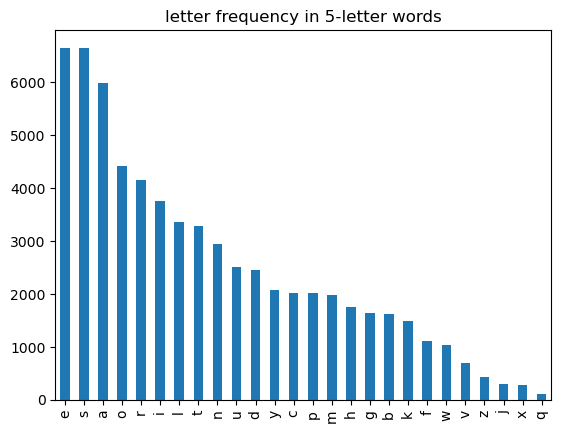

In [7]:
# letter prevalence as a whole
(five_letter_words
    .apply(lambda x: list(x))
    .explode()
    .value_counts()
    .plot(
        kind="bar",
        title="letter frequency in 5-letter words",
        ));

<Axes: title={'center': 'How often does a letter appear in a 5 letter word?'}>

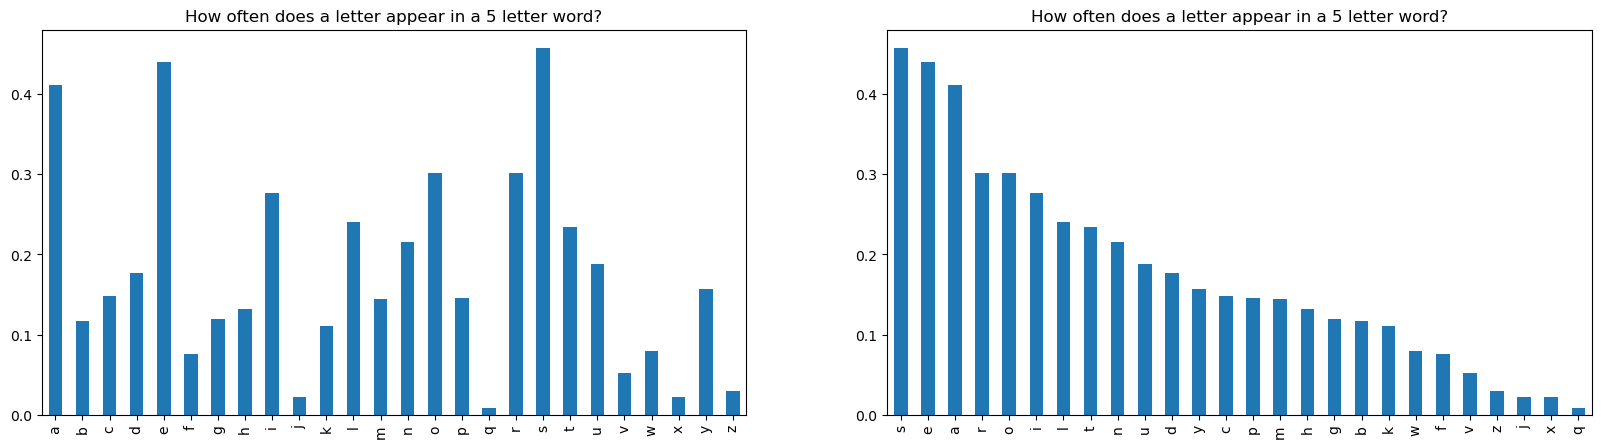

In [8]:
ALPHABET = "abcdefghijklmnopqrstuvwxyz"
# how often does a letter appear in a 5 letter word?
letter_frequency = pd.Series({letter: five_letter_words.str.contains(letter).mean() for letter in ALPHABET})

fig, ax = plt.subplots(1,2, figsize=(20,5))
letter_frequency.plot.bar(title="How often does a letter appear in a 5 letter word?", ax=ax[0])
letter_frequency.sort_values(ascending=False).plot.bar(title="How often does a letter appear in a 5 letter word?", ax=ax[1])

In [9]:
sample_words = np.random.choice(list(allowed_words.keys()), 200, replace=False)
sample_words = {word: allowed_words[word] for word in sample_words}

## Building a map of possible solutions given a guess outcome

In [15]:

psm = wd.PossibleSolutionsMap(allowed_words, list(allowed_words))
%time psm.build_map()
print(psm)

%time psm.to_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v1"))

CPU times: user 14min 13s, sys: 35.9 s, total: 14min 49s
Wall time: 15min 13s
PossibleSolutionsMap(n_solutions=12953,n_allowed=12953,entropy=13.66)
CPU times: user 1min 5s, sys: 2min 51s, total: 3min 57s
Wall time: 4min 31s


## Version using prior knowledge about actual possible words

In [34]:
psm_v2 = wd.PossibleSolutionsMap({word: 1.0 for word in possible_words}, list(allowed_words))
%time psm_v2.build_map()
print(psm_v2)

%time psm_v2.to_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v2"))

CPU times: user 2min 25s, sys: 2.17 s, total: 2min 27s
Wall time: 2min 27s
PossibleSolutionsMap(n_solutions=2309,n_allowed=12953,entropy=11.17)
CPU times: user 7.8 s, sys: 464 ms, total: 8.26 s
Wall time: 8.4 s


In [10]:
# reload
psm = wd.PossibleSolutionsMap.from_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v1"))
psm_v2 = wd.PossibleSolutionsMap.from_pickle(DATA_PATH / WORDS_PAIRS_FNAME.format(version="v2"))

In [11]:
def simulate_game_so_far(solution: str, guesses: list[str]):
    game = wd.WordleGame(solution)
    for guess in guesses:
        game.record_player_guess(guess)
        wd.display_wordle_guess_outcome(game.guesses_so_far[-1])
    
    return game

In [12]:
game = simulate_game_so_far("bread", ["crate"]) 
%time psm2 = psm.filter_based_on_guess_outcome(game.guesses_so_far[-1])
print(psm2)
print(psm2.possible_solutions.head())

CPU times: user 301 ms, sys: 545 ms, total: 846 ms
Wall time: 894 ms
PossibleSolutionsMap(n_solutions=34,n_allowed=12953,entropy=5.09)
ardeb    1.0
aread    1.0
areal    1.0
arear    1.0
areas    1.0
dtype: float64


## test performance with caching of entropies calculation for all candidates

In [13]:
# game start: all words are possible solutions (map = 13k x 13k)
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm)
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm)

# after one guess: 
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm2)

CPU times: user 12.1 s, sys: 2.19 s, total: 14.3 s
Wall time: 15.2 s
CPU times: user 520 µs, sys: 26 µs, total: 546 µs
Wall time: 549 µs
CPU times: user 3.28 s, sys: 207 ms, total: 3.49 s
Wall time: 3.58 s


In [14]:
%time candidate_entropies = wd.player.get_all_candidate_entropies(psm_v2)

CPU times: user 5.1 s, sys: 514 ms, total: 5.62 s
Wall time: 5.78 s


In [18]:
player.psm.map

,aahed,aalii,aargh,aarti,abaca,abaci,aback,abacs,abaft,abaka,...,zulus,zupan,zupas,zuppa,zurfs,zuzim,zygal,zygon,zymes,zymic
grown,_____,_____,__OO_,__O__,_____,_____,_____,_____,_____,_____,...,_____,____C,_____,_____,__O__,_____,__O__,__OOC,_____,_____


In [46]:
player.psm

PossibleSolutionsMap(n_solutions=0,n_allowed=12953,entropy=-0.00)

In [51]:
player = wd.player.GreedyPlayer(psm_v2)
game = wd.WordleGame("broad")
%time wd.player.play_game(player, game=game)



CPU times: user 3.54 s, sys: 72.2 ms, total: 3.61 s
Wall time: 3.6 s


WordleGame(target_word='BROAD', max_guesses=6, number_of_guesses=3, is_over=True, solved=True)

In [24]:
wd.player.get_all_candidate_entropies.cache_clear()

In [25]:
player = wd.player.GreedyPlayer(psm)
game = wd.WordleGame("grown")
guess = player.make_next_guess(game)

In [26]:
guess

'tares'

In [ ]:
print(pd.Series.to_string(float_format=))

In [29]:
print(gopm2)
candidate_entropies.head(8)

Guess2PossibleSolutionsMap(n_solutions=34,n_allowed=12953,entropy=5.09)


aread    3.402633
arsed    3.385277
arled    3.274265
armed    3.112212
bread    3.104347
areas    3.098473
arked    3.059942
dream    3.035274
dtype: float64

In [25]:
# outcome = game.record_player_guess(candidate_entropies.index[0])
gopm3 = gopm2.filter_based_on_guess_outcome(outcome)
print(gopm3)

Guess2PossibleSolutionsMap(n_solutions=3,n_allowed=12953,entropy=1.58)


In [26]:
gopm3.possible_solutions

bread    1.0
dread    1.0
oread    1.0
dtype: float64

In [31]:
# to be refactored
def generate_word_distrib(word, gopm = gopm):
    distrib = {pattern: {"probability": probability(possibilities), "possibilities": list(possibilities.keys())[:8]} for pattern, possibilities in gopm.map[word].items()}
    distrib = pd.DataFrame(distrib).T
    distrib = distrib.sort_values("probability", ascending=False)
    distrib.probability /= distrib.probability.sum()
    distrib = distrib.reset_index().rename(columns={'index': 'pattern'})
    return distrib

def plot_distrib(word, gopm = gopm):
    distrib = generate_word_distrib(word, gopm)
    fig = px.bar(
        distrib, 
        x='pattern', 
        y="probability", 
        hover_data=distrib.columns, 
        template="plotly_dark", 
        title=f"wordle outcome distribution for first guess `{word}`")
    fig.show()

In [32]:
plot_distrib("kayak")

AttributeError: 'str' object has no attribute 'values'

In [56]:
def entropy(word, gopm_map=gopm.map):
    distrib = np.array([probability(possibilities) for possibilities in gopm_map[word].values()])
    probabilities = distrib[distrib > 0] / distrib.sum()
    return (-probabilities * np.log2(probabilities)).sum()

entropies = pd.Series({word: entropy(word) for word in allowed_words})


In [35]:
entropies.sort_values(ascending=False).head(10)

tares    6.195595
lares    6.151314
rales    6.115942
rates    6.097615
teras    6.078258
nares    6.068445
soare    6.062303
tales    6.056305
reais    6.051229
tears    6.033782
dtype: float64

In [ ]:
possibilities = gopm.get_possibilities